In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# manually add a2e-mmc repos to PYTHONPATH if needed
import sys
module_path = os.path.join(os.environ['HOME'],'a2e-mmc')
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from mmctools.dataloaders import read_dir
from mmctools.measurements.radar import profiler
from mmctools.plotting import plot_timeheight, plot_profile

# Process TTU Radar Data
written by [Eliot Quon](mailto:eliot.quon@nrel.gov)

To generate driving data for MMC diurnal study

In [5]:
# analysis range
starttime = '2013-11-08 12:00'
endtime = '2013-11-09 12:02' # extend past 12:00 to include one more snapshot

In [6]:
# 10-min tower data generated by `process_TTU_tower.ipynb`
towerdata = 'data/TTU_tilt_corrected_20131108-09_10min.csv'
#towerdata = '/Users/equon/MMC/SWIFTRegion/8Nov2013/TTU_tower_20131108_10min.csv'

In [7]:
# data manually downloaded from DAP
radardir = 'data/mmc.radar.z01.00'

In [8]:
# output data for further analyses
winds_output = 'data/radar_winds.z01.00_20131108.csv'
rass_output = 'data/radar_rass.z01.00_20131108.csv'

In [9]:
# where to save figures
fig_output = 'figures'
if not os.path.isdir(fig_output):
    os.makedirs(fig_output)

## Read data
Note: According to the [DAP](https://a2e.energy.gov/data/mmc/radar.z01.00), the timestamp is:
> Averaged at interval of `20 UTC` at the **start** of the bin

In contrast, pandas rolling/resample operations place the timestamp at the **end** of the sampling interval.

In [10]:
# period of interest
starttime = pd.to_datetime(starttime)
endtime = pd.to_datetime(endtime)

### Radar: WINDS output

In [11]:
winds_scantypes = []
winds = read_dir(radardir, file_filter='*_w*.cns',
                 reader=profiler,
                 # profiler parameters:
                 scans=None, # read all scans
                 read_scan_properties=winds_scantypes,
                 check_na=['SPD','DIR','SNR'], na_values=999999,
                 #verbose=True,
                )
winds = winds.reset_index()
winds['height'] *= 1000 # [m]
if winds_output is not None:
    winds.set_index(['datetime','height']).to_csv(winds_output)

In [12]:
# standardize variable names
winds = winds.rename(columns={
    'SPD': 'wspd',
    'DIR': 'wdir',
})

3 different scans found in the data during the two days; only scan0 and scan1 were used during the period of interest, alternating every ~10 min

In [13]:
winds_scantypes

[{'station': 'Reese Center',
  'data_format': 'WINDS    rev 5.1',
  'consensus_avg_time_min': 16,
  'num_beams': 4,
  'num_range_gates': 30,
  'beam:reqd_records_for_consensus': [4, 4, 4, 4],
  'beam:tot_num_records': [6, 6, 6, 6],
  'beam:consensus_window_size_m/s': [3.0, 3.0, 3.0, 3.0],
  'num_coherent_integrations': [132, 999999],
  'num_spectral_averages': [42, 999999],
  'pulse_width_ns': [400, 999999],
  'inner_pulse_period_ms': [31, 999999],
  'fullscale_doppler_value_m/s': [20.0, 999999.0],
  'vertical_correction_to_obliques': True,
  'delay_to_first_gate_ns': [2850, 999999],
  'num_gates': [30, 999999],
  'gate_spacing_ns': [400, 999999],
  'beam:azimuth_deg': [90.0, 0.0, 270.0, 180.0],
  'beam:elevation_deg': [66.4, 66.4, 66.4, 66.4]},
 {'station': 'Reese Center',
  'data_format': 'WINDS    rev 5.1',
  'consensus_avg_time_min': 15,
  'num_beams': 4,
  'num_range_gates': 30,
  'beam:reqd_records_for_consensus': [3, 3, 3, 4],
  'beam:tot_num_records': [5, 5, 5, 6],
  'beam:cons

range gates for the 3 scans

In [14]:
for itype,scaninfo in enumerate(winds_scantypes):
    print('scan',itype, winds.loc[winds['scan_type']==itype,'height'].unique())

scan 0 [ 151.  206.  261.  316.  371.  426.  481.  536.  590.  645.  700.  755.
  810.  865.  920.  975. 1030. 1085. 1140. 1195. 1250. 1305. 1359. 1414.
 1469. 1524. 1579. 1634. 1689. 1744.]
scan 1 [ 611.  803.  996. 1188. 1380. 1572. 1765. 1957. 2149. 2341. 2534. 2726.
 2918. 3110. 3303. 3495. 3687. 3879. 4072. 4264. 4456. 4648. 4841. 5033.
 5225. 5417. 5610. 5802. 5994. 6186.]
scan 2 [ 611.  803.  996. 1188. 1380. 1572. 1765. 1957. 2149. 2341. 2534. 2726.
 2918. 3110. 3303. 3495. 3687. 3879. 4072. 4264. 4456. 4648. 4841. 5033.
 5225. 5417. 5610. 5802. 5994. 6186.]


### Radar: RASS output

In [15]:
rass_scantypes = []
rass = read_dir(radardir, file_filter='*_t*.cns',
                reader=profiler,
                # profiler parameters:
                scans=None, # read all scans
                read_scan_properties=rass_scantypes,
                check_na=['T','Tc','W','SNR'], na_values=999999,
                #verbose=True,
            )
rass = rass.reset_index()
rass['height'] *= 1000 # [m]
if rass_output is not None:
    rass.set_index(['datetime','height']).to_csv(rass_output)

In [16]:
rass_scantypes

[{'station': 'Reese Center',
  'data_format': 'RASS    rev 5.1',
  'consensus_avg_time_min': 3,
  'num_beams': 1,
  'num_range_gates': 25,
  'beam:reqd_records_for_consensus': [9],
  'beam:tot_num_records': [14],
  'beam:consensus_window_size_m/s': [3.0],
  'num_coherent_integrations': 9,
  'num_spectral_averages': 28,
  'pulse_width_ns': 400,
  'inner_pulse_period_ms': 23,
  'fullscale_doppler_value_m/s': 395.7,
  'vertical_correction_to_obliques': 'n/a',
  'delay_to_first_gate_ns': 2850,
  'num_gates': 25,
  'gate_spacing_ns': 400,
  'beam:azimuth_deg': [0.0],
  'beam:elevation_deg': [90.0]},
 {'station': 'Reese Center',
  'data_format': 'RASS    rev 5.1',
  'consensus_avg_time_min': 3,
  'num_beams': 1,
  'num_range_gates': 25,
  'beam:reqd_records_for_consensus': [8],
  'beam:tot_num_records': [13],
  'beam:consensus_window_size_m/s': [3.0],
  'num_coherent_integrations': 9,
  'num_spectral_averages': 28,
  'pulse_width_ns': 400,
  'inner_pulse_period_ms': 23,
  'fullscale_doppler_

In [17]:
for itype,scaninfo in enumerate(rass_scantypes):
    print('scan',itype, rass.loc[rass['scan_type']==itype,'height'].unique())

scan 0 [ 165.  225.  285.  345.  405.  465.  524.  584.  644.  704.  764.  824.
  884.  944. 1004. 1064. 1124. 1184. 1244. 1304. 1364. 1424. 1484. 1543.
 1603.]
scan 1 [ 165.  225.  285.  345.  405.  465.  524.  584.  644.  704.  764.  824.
  884.  944. 1004. 1064. 1124. 1184. 1244. 1304. 1364. 1424. 1484. 1543.
 1603.]
scan 2 [ 165.  225.  285.  345.  405.  465.  524.  584.  644.  704.  764.  824.
  884.  944. 1004. 1064. 1124. 1184. 1244. 1304. 1364. 1424. 1484. 1543.
 1603.]


In [18]:
inrange = (rass['datetime'] >= starttime) & (rass['datetime'] <= endtime)
rass = rass.loc[inrange]
rass = rass.set_index(['datetime','height'])

### 200-m tower
reference data near the ground

Note: to line up with radar data, shift timestamps from *end* of 10-min interval to the *beginning*

In [19]:
tower = pd.read_csv(towerdata,parse_dates=['datetime'])

In [20]:
# shift timestamps by 10-min to match radar timestamps
tower['datetime'] -= pd.to_timedelta('10min')

In [21]:
inrange = (tower['datetime'] >= starttime) & (tower['datetime'] <= endtime)
tower = tower.loc[inrange]
tower = tower.set_index(['datetime','height'])

In [22]:
tower['wspd'] = np.sqrt(tower['u']**2 + tower['v']**2)

In [23]:
tower['wdir'] = np.degrees(np.arctan2(-tower['u'],-tower['v']))
tower.loc[tower['wdir']<0,'wdir'] += 360.

## Analyze scan "0" (near-ground)

In [24]:
scan0 = winds.loc[winds['scan_type']==0]
inrange = (scan0['datetime'] >= starttime) & (scan0['datetime'] <= endtime)
scan0 = scan0.loc[inrange]
scan0 = scan0.set_index(['datetime','height'])

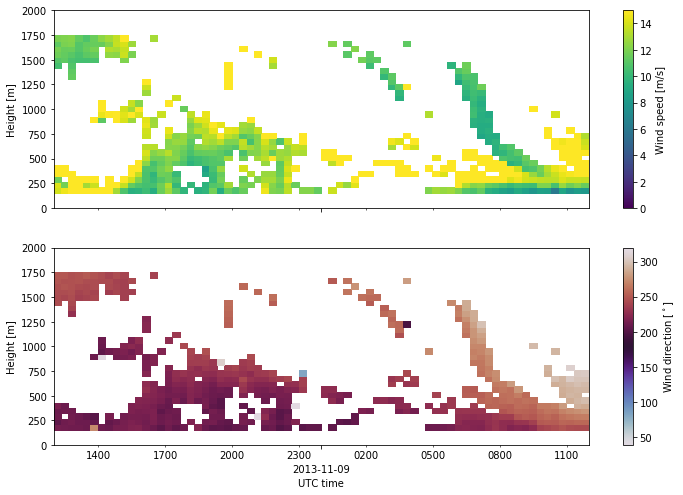

In [25]:
fig,ax,cbars = plot_timeheight(scan0,
                               fields=['wspd','wdir'],
                               fieldlimits={'wspd':(0,15)},
                               heightlimits=(0,2000),
                              )
fig.savefig(os.path.join(fig_output,'scan0_20min.png'),
            dpi=150,bbox_inches='tight')

### add tower data

In [26]:
freq_20min = pd.date_range(start=starttime,end=endtime,freq='20min')

In [27]:
assert len(scan0.index.levels[0])==len(freq_20min)

In [28]:
# force scan timestamps to line up exactly at 20-min intervals by overwriting the index
scan0_20min = scan0[['wspd','wdir','scan_type']].unstack().set_index(freq_20min)

In [29]:
# interpolate 
# - default method: "linear", assuming equally spaced data points
# - limit area: "inside" to not extrapolate unbounded nan regions
# - NOTE: holes are too big to fill!
scan0_10min = scan0_20min.resample('10min').interpolate(method='linear',
                                                        limit=1,limit_area='inside').stack()

In [30]:
tower['scan_type'] = -1 
scan0_tower = scan0_10min.append(tower[['wspd','wdir','scan_type']]).sort_index()

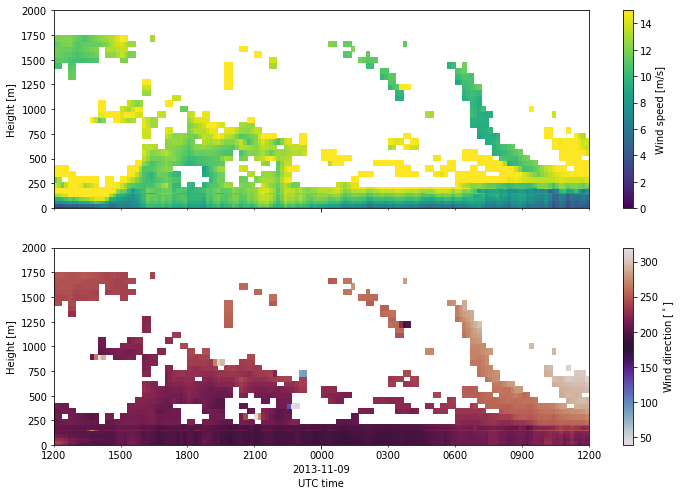

In [31]:
fig,ax,cbars = plot_timeheight(scan0_tower,
                               fields=['wspd','wdir'],
                               fieldlimits={'wspd':(0,15)},
                               heightlimits=(0,2000),
                              )
fig.savefig(os.path.join(fig_output,'scan0_tower_10min.png'),
            dpi=150,bbox_inches='tight')

at this point, the `scan_type` flag will indicate:
- -1: tower data, up to 200 m
- 0: radar scan "0", up to 1744 m
- 1: radar scan "1", up to 6186 m

## Analyze scan "1"

In [32]:
scan1 = winds.loc[winds['scan_type']==1]
inrange = (scan1['datetime'] >= starttime) & (scan1['datetime'] <= endtime)
scan1 = scan1.loc[inrange]
scan1 = scan1.set_index(['datetime','height'])

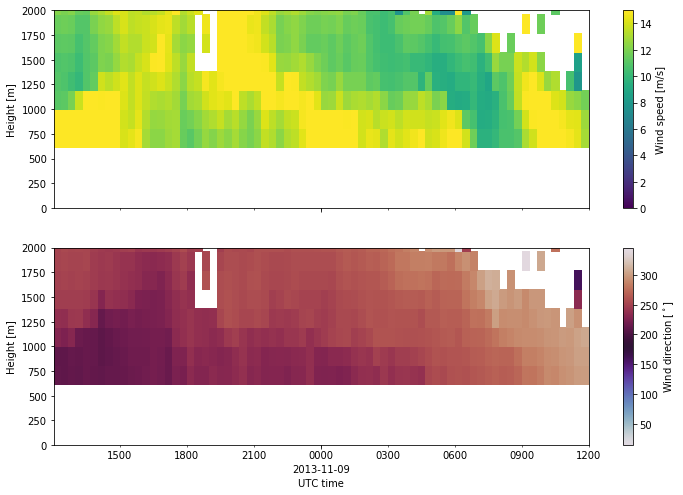

In [33]:
fig,ax,cbars = plot_timeheight(scan1,
                               fields=['wspd','wdir'],
                               fieldlimits={'wspd':(0,15)},
                               heightlimits=(0,2000), # heightlimits=(0,3000),
                              )
fig.savefig(os.path.join(fig_output,'scan1_20min.png'),
            dpi=150,bbox_inches='tight')

### overlay plot

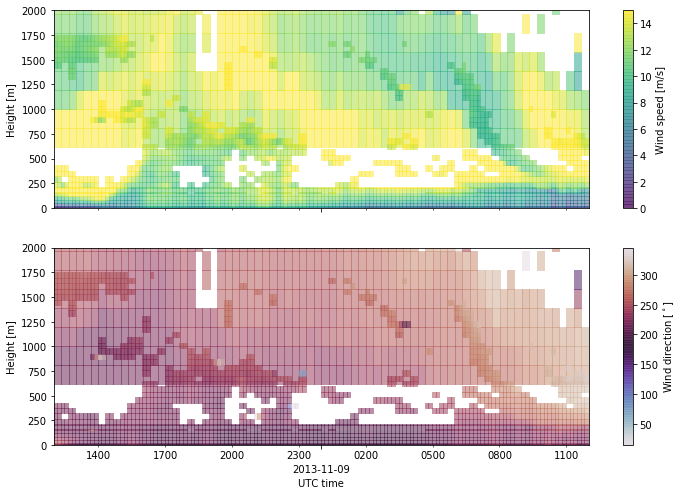

In [34]:
fig,ax,cbars = plot_timeheight(scan1,
                               fields=['wspd','wdir'],
                               fieldlimits={'wspd':(0,15)},
                               heightlimits=(0,2000),
                               alpha=0.5,
                              )
_,_,_ = plot_timeheight(scan0_tower,
                        fields=['wspd','wdir'],
                        fieldlimits={'wspd':(0,15)},
                        heightlimits=(0,2000),
                        alpha=0.5,
                        fig=fig,ax=ax,showcolorbars=False,
                       )
fig.savefig(os.path.join(fig_output,'all_data_10min.png'),
            dpi=150,bbox_inches='tight')

### combine all data

In [35]:
# neglect ~1 min offset between scan0 and scan1
scan1_20min = scan1[['wspd','wdir','scan_type']].unstack().set_index(freq_20min)

In [36]:
# resample to 10 min
scan1_10min = scan1_20min.resample('10min').interpolate(method='linear',limit=1,limit_area='inside').stack()

In [37]:
# now everything is at 10-min intervals
alldata = scan0_tower.append(scan1_10min).sort_index().reset_index()
alldata = alldata.rename(columns={'level_0':'datetime'})

In [38]:
# calculate an integer time index for griddata
toffset = pd.to_timedelta('10min')
alldata['t_index'] = (alldata['datetime'] - starttime) / toffset

In [39]:
alldata

,datetime,height,wspd,wdir,scan_type,t_index
0,2013-11-08 12:00:00,0.9,1.225746,219.005685,-1.0,0.0
1,2013-11-08 12:00:00,2.4,1.772110,225.353123,-1.0,0.0
2,2013-11-08 12:00:00,4.0,2.046332,229.267605,-1.0,0.0
3,2013-11-08 12:00:00,10.1,2.979477,233.780026,-1.0,0.0
4,2013-11-08 12:00:00,16.8,3.944645,239.036134,-1.0,0.0
5,2013-11-08 12:00:00,47.3,7.112991,229.559781,-1.0,0.0
6,2013-11-08 12:00:00,74.7,9.368508,215.581960,-1.0,0.0
7,2013-11-08 12:00:00,116.5,12.904569,208.141227,-1.0,0.0
8,2013-11-08 12:00:00,151.0,14.000000,214.000000,0.0,0.0
9,2013-11-08 12:00:00,158.2,14.911582,205.381249,-1.0,0.0


filter out data that aren't needed for the analysis

In [40]:
len(alldata)

10150

In [41]:
# exclude high altitude data from interpolation
alldata = alldata.loc[alldata['height'] <= 2500]
len(alldata)

7250

In [42]:
# get rid of nans...
alldata = alldata.loc[~pd.isna(alldata['wspd'])]
len(alldata)

3814

In [43]:
# calculate velocity components
ang = np.radians(270-alldata['wdir'])
alldata['u'] = alldata['wspd'] * np.cos(ang)
alldata['v'] = alldata['wspd'] * np.sin(ang)

In [44]:
# write out combined data (to be QC'd later)
alldata.set_index('datetime')[['height','t_index','scan_type','wspd','wdir','u','v']].to_csv(
    'data/combined_radar_data.csv'
)

check combined data

In [45]:
assert not pd.isna(alldata['wspd']).any()
assert not pd.isna(alldata['wdir']).any()

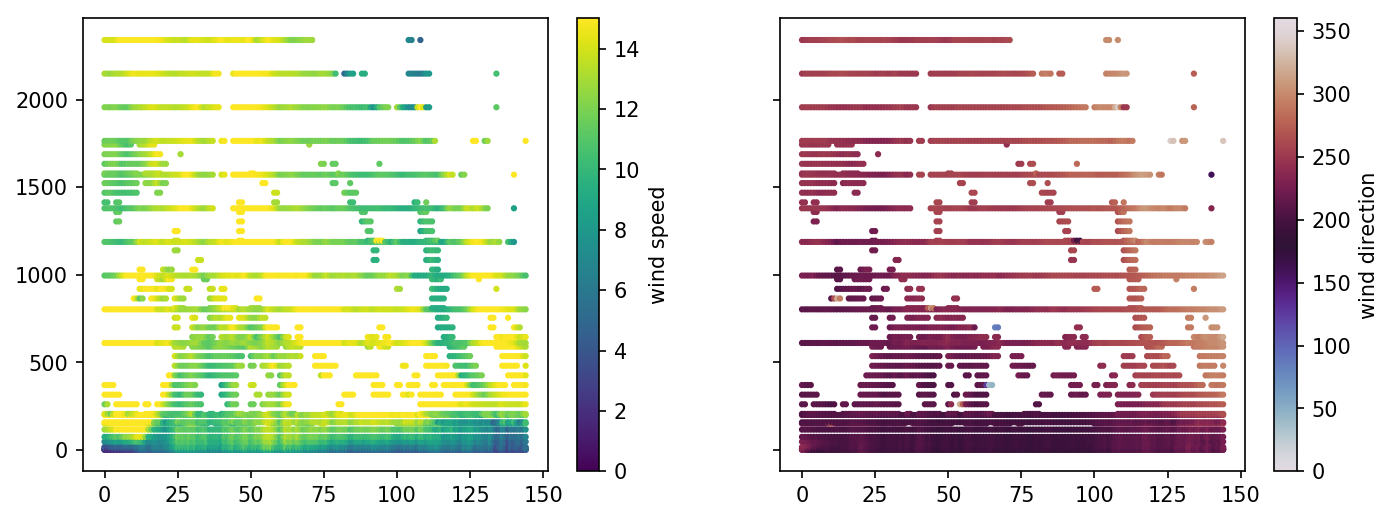

In [46]:
fig,ax = plt.subplots(ncols=2,sharex=True,sharey=True,figsize=(11,4),dpi=150)
scat = ax[0].scatter(alldata['t_index'],alldata['height'],c=alldata['wspd'],vmin=0,vmax=15,s=4)
cbar = fig.colorbar(scat,label='wind speed',ax=ax[0])
scat = ax[1].scatter(alldata['t_index'],alldata['height'],c=alldata['wdir'],vmin=0,vmax=360,cmap='twilight',s=4)
cbar = fig.colorbar(scat,label='wind direction',ax=ax[1])

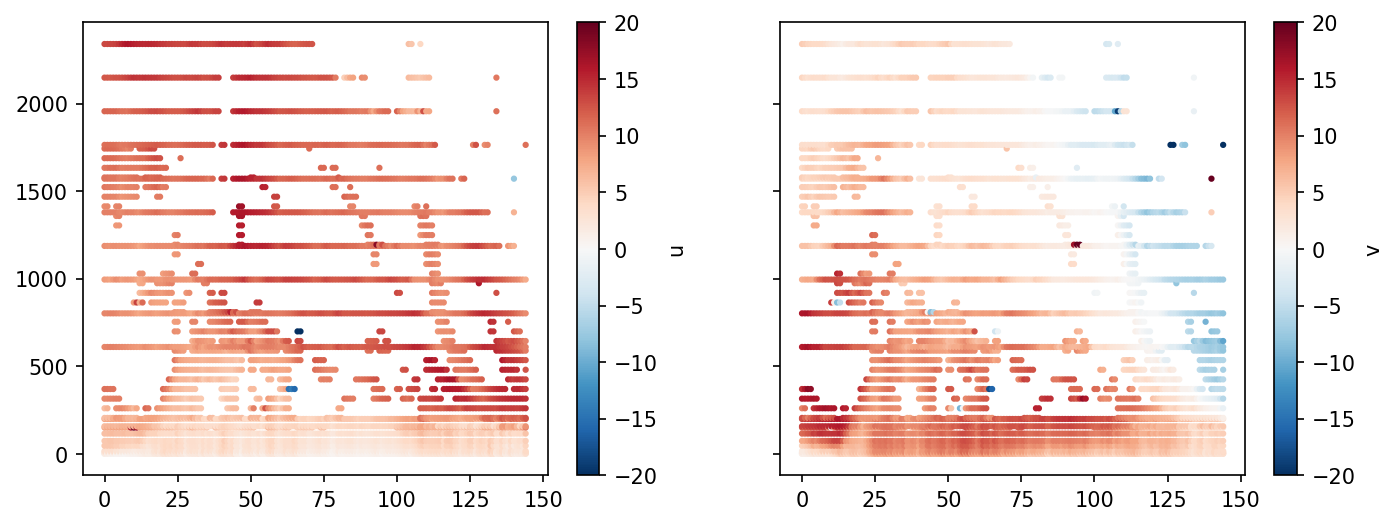

In [47]:
fig,ax = plt.subplots(ncols=2,sharex=True,sharey=True,figsize=(11,4),dpi=150)
scat = ax[0].scatter(alldata['t_index'],alldata['height'],c=alldata['u'],s=4,
                     cmap='RdBu_r',vmin=-20,vmax=20)
cbar = fig.colorbar(scat,ax=ax[0],label='u')
scat = ax[1].scatter(alldata['t_index'],alldata['height'],c=alldata['v'],s=4,
                     cmap='RdBu_r',vmin=-20,vmax=20)
cbar = fig.colorbar(scat,ax=ax[1],label='v')

## Natural neighbor interpolation/extrapolation
to generate regular data for use with microscale profile assimilation--this requires an additional python library which may be installed with `pip install naturalneighbor`

In [48]:
import naturalneighbor

In [49]:
# output grid _point_ definition (min, max, ds)
# griddata will interpolate to cell _centers_
dz = 20.
tdef = [-0.5, len(scan0_tower.index.levels[0])-0.5, 1] # [10 min]
zdef = [0, 2000, dz] # [m]
griddef = [tdef, zdef, [-0.5,0.5,1]]
griddef

[[-0.5, 144.5, 1], [0, 2000, 20.0], [-0.5, 0.5, 1]]

In [50]:
# check grid definition
tindex  = np.arange(griddef[0][0], griddef[0][1]+0.001, 1)
z  = np.arange(griddef[1][0], griddef[1][1]+0.001, dz)
na = np.arange(griddef[2][0], griddef[2][1]+0.001, 1)
assert(len(tindex) == len(scan0_tower.index.levels[0])+1)
assert(len(na) == 2)

In [51]:
# setup output grid
times = starttime + pd.to_timedelta(tindex*toffset)
tgrid, zgrid = np.meshgrid(times, z, indexing='ij')

In [52]:
# setup "3D" list of interpolation points
xi = alldata['t_index']
yi = alldata['height']
zi = np.zeros(len(xi))

In [53]:
# perform the interpolation, now that we have all the inputs that griddata expects
points = np.stack((xi,yi,zi),axis=-1)
wspd_interp = naturalneighbor.griddata(points, alldata['wspd'], griddef).squeeze() # squeeze out "z" dimension
wdir_interp = naturalneighbor.griddata(points, alldata['wdir'], griddef).squeeze()

In [54]:
# multi-index for reconstructing dataframe
midx = pd.MultiIndex.from_product([times[:-1], z[:-1]])

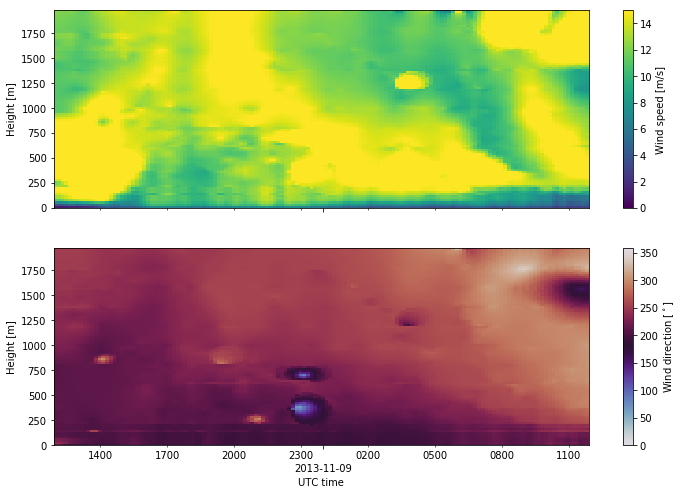

In [55]:
df = pd.DataFrame(data={'wspd':wspd_interp.ravel(), 'wdir':wdir_interp.ravel()}, index=midx)
fig,ax,cbars = plot_timeheight(df,
                               fields='all',
                               fieldlimits={'wspd':(0,15), 'wdir':(0,360)})
fig.savefig(os.path.join(fig_output,'all_data_NNinterp.png'),
            dpi=150,bbox_inches='tight')

### Use quality controlled data
<font color='blue'>Performed using `manual_qc.py` tool from https://github.com/ewquon/analysis/blob/master/swift/manual_qc.py</font>

May be possible to use spectrum output for QC process (according to Brandon Ennis)

In [56]:
qcdata = pd.read_csv('data/combined_radar_data_qc.csv',parse_dates=['datetime'])

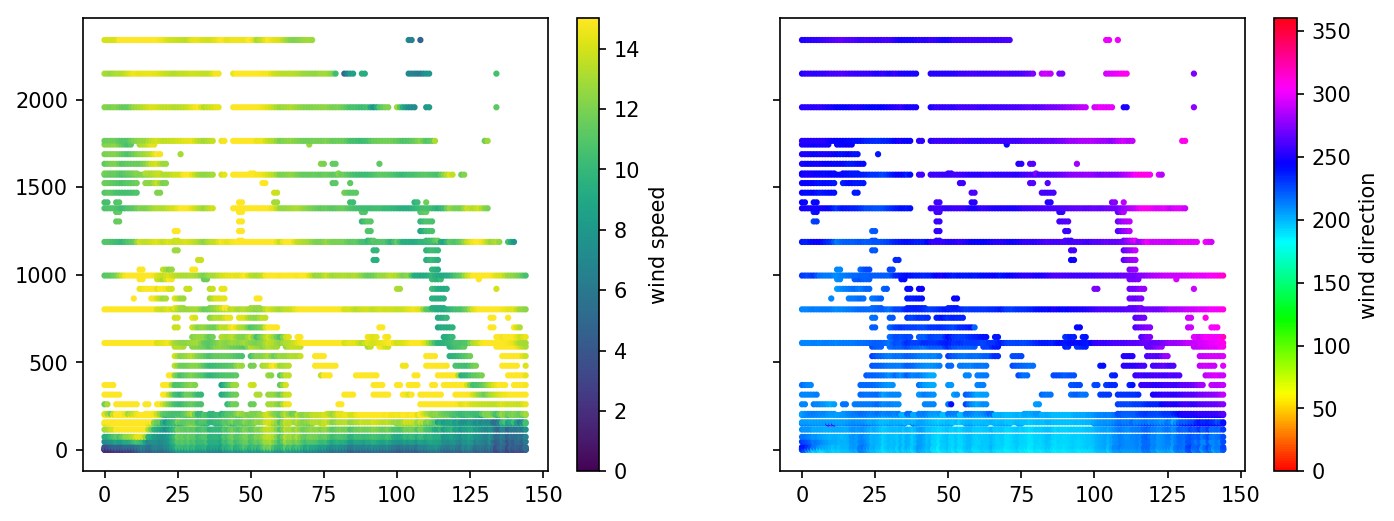

In [57]:
fig,ax = plt.subplots(ncols=2,sharex=True,sharey=True,figsize=(11,4),dpi=150)
scat = ax[0].scatter(qcdata['t_index'],qcdata['height'],c=qcdata['wspd'],vmin=0,vmax=15,s=4)
cbar = fig.colorbar(scat,label='wind speed',ax=ax[0])
scat = ax[1].scatter(qcdata['t_index'],qcdata['height'],c=qcdata['wdir'],vmin=0,vmax=360,cmap='hsv',s=4)
cbar = fig.colorbar(scat,label='wind direction',ax=ax[1])

In [58]:
xi_qc = qcdata['t_index']
yi_qc = qcdata['height']
zi_qc = np.zeros(len(xi_qc))
points = np.stack((xi_qc,yi_qc,zi_qc),axis=-1)
wspd_interp_qc = naturalneighbor.griddata(points, qcdata['wspd'], griddef).squeeze()
wdir_interp_qc = naturalneighbor.griddata(points, qcdata['wdir'], griddef).squeeze()

In [59]:
np.savez_compressed('data/NNinterp_TTU_data_20131108.npz',
                    qcdata=qcdata,
                    tgrid=tgrid,zgrid=zgrid,
                    wspd_interp=wspd_interp_qc,
                    wdir_interp=wdir_interp_qc,
                   )

In [60]:
# save pandas dataframe, results in substantially larger file

# freq_10min = pd.date_range(starttime,endtime,freq='10min') # time index, level 0
# z_mid = (z[:-1] + z[1:]) / 2 # height index, level 1
# wspd = pd.DataFrame(wspd_interp_qc,index=freq_10min,columns=z_mid).stack() # windspeed series
# wdir = pd.DataFrame(wdir_interp_qc,index=freq_10min,columns=z_mid).stack() # winddirection series
# wspd.name = 'windspeed_m/s'
# wdir.name = 'winddirection_deg'
# df = pd.concat((wspd,wdir),axis=1) # combine into dataframe
# df.index.rename(['datetime','height'],inplace=True)
# df.to_csv('data/NNinterp_TTU_data_20131108.csv')

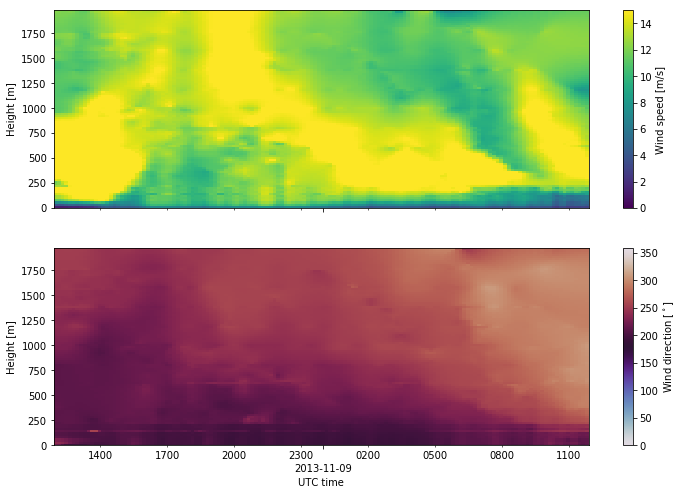

In [61]:
df = pd.DataFrame(data={'wspd':wspd_interp_qc.ravel(), 'wdir':wdir_interp_qc.ravel()}, index=midx)
fig,ax,cbars = plot_timeheight(df,
                               fields='all',
                               fieldlimits={'wspd':(0,15), 'wdir':(0,360)})
fig.savefig(os.path.join(fig_output,'QC_data_NNinterp.png'),
            dpi=150,bbox_inches='tight')

## Analyze wind data SNR

In [62]:
SNR_fields = ['SNR.0','SNR.1','SNR.2','SNR.3']

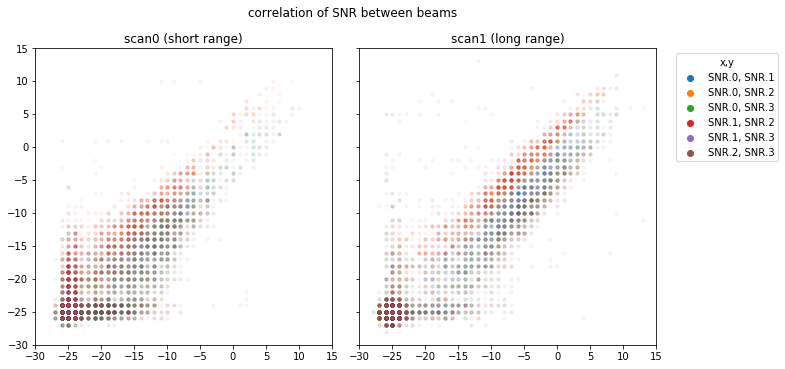

In [63]:
fig,ax = plt.subplots(ncols=2,sharex=True,sharey=True,figsize=(11,5.5))
styles = dict(s=10, alpha=0.05)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
idx = 0
for i in range(3):
    for j in range(i+1,4):
        color = colors[idx]
        ax[0].scatter(scan0[SNR_fields[i]], scan0[SNR_fields[j]], c=color, label='', **styles)
        ax[1].scatter(scan1[SNR_fields[i]], scan1[SNR_fields[j]], c=color, label='', **styles)
        # legend hack
        ax[1].scatter(50,50, c=color, label='{:s}, {:s}'.format(SNR_fields[i], SNR_fields[j]))
        idx += 1
ax[0].axis('scaled')
ax[1].axis('scaled')
ax[1].set_xlim((-30,15))
ax[1].set_ylim((-30,15))
ax[0].set_title('scan0 (short range)')
ax[1].set_title('scan1 (long range)')
ax[1].legend(loc='upper left',bbox_to_anchor=(1.05,1),title='x,y')
fig.suptitle('correlation of SNR between beams',x=0.45)
plt.tight_layout()

Text(0.5, 1.0, 'scan1 (long range)')

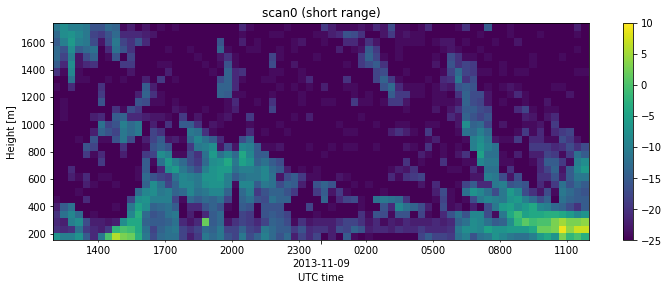

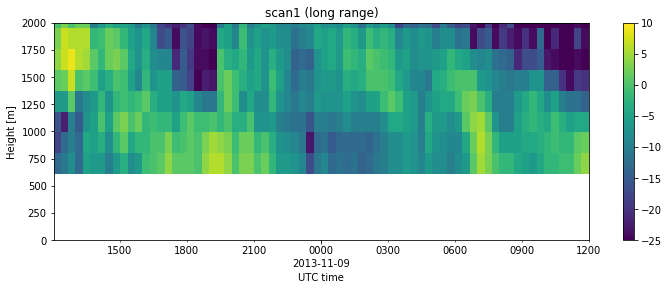

In [64]:
#fig,ax,cbars = plot_timeheight(scan0,fields=SNR_fields)
#fig,ax,cbars = plot_timeheight(scan1,fields=SNR_fields,heightlimits=(0,2000))

vmin,vmax = -25, 10

fig,ax,cbars = plot_timeheight(scan0, fields='SNR.0', fieldlimits=(vmin,vmax))
ax.set_title('scan0 (short range)')

fig,ax,cbars = plot_timeheight(scan1, fields='SNR.0', fieldlimits=(vmin,vmax), heightlimits=(0,2000))
ax.set_title('scan1 (long range)')

In [65]:
times_of_interest = ['2013-11-08 18:00',
                     '2013-11-08 22:00',
                     '2013-11-09 06:00']

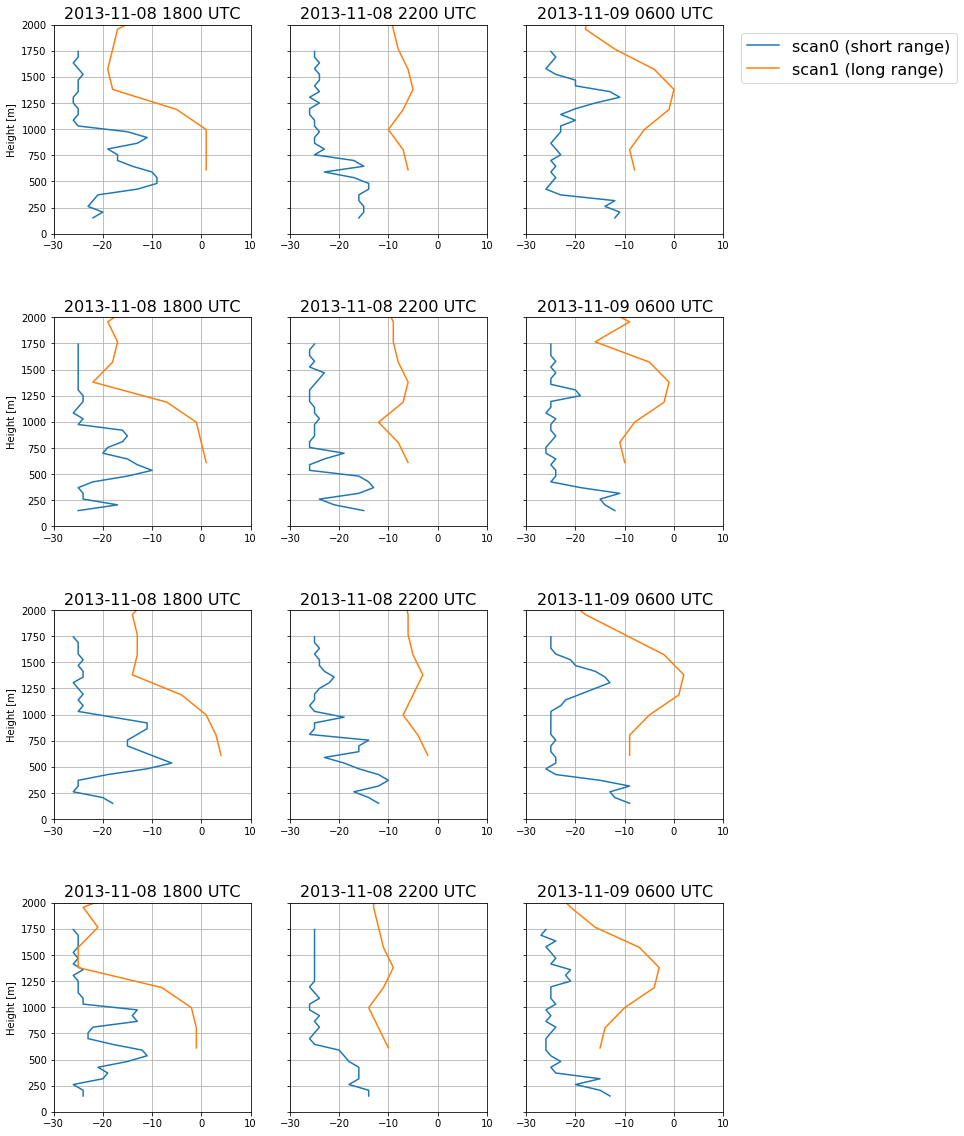

In [66]:
# note `scan0` and `scan1` have irregular timestamps (not exactly 20-min intervals)
vmin,vmax = -30,10
scan0_SNR = scan0[SNR_fields].unstack().set_index(freq_20min).stack()
scan1_SNR = scan1[SNR_fields].unstack().set_index(freq_20min).stack()
fig,ax = plot_profile({'scan0 (short range)':scan0_SNR,
                       'scan1 (long range)':scan1_SNR },
                      fields='all',
                      times=times_of_interest,
                      stack_by_datasets=True,
                      fieldlimits={plotvar:(vmin,vmax) for plotvar in SNR_fields},
                      heightlimits=(0,2000))

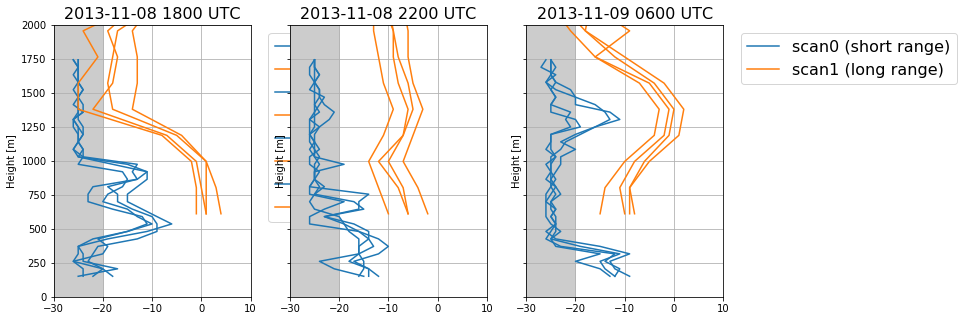

In [67]:
fig,ax = plot_profile({'scan0 (short range)':scan0_SNR,
                       'scan1 (long range)':scan1_SNR },
                      fields='SNR.0',
                      times=times_of_interest,
                      stack_by_datasets=True,
                      fieldlimits=(vmin,vmax),
                      heightlimits=(0,2000))
for plotvar in SNR_fields[1:]:
    plot_profile({'scan0 (short range)':scan0_SNR,
                  'scan1 (long range)':scan1_SNR },
                 fields=plotvar,
                 times=times_of_interest,
                 stack_by_datasets=True,
                 fieldlimits=(vmin,vmax),
                 heightlimits=(0,2000),
                 fig=fig,ax=ax)
for axi in ax:
    axi.axvspan(-30,-20,color='0.8')

## Analyze temperature data
*Not* analyzed in detail during the period of interest due to the limited quantity/quality of data

In [68]:
rass_times = rass.index.levels[0]
rass_heights = rass.index.levels[1]
tt,zz = np.meshgrid(rass_times,rass_heights,indexing='ij')

/Users/equon/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(0, 1000)

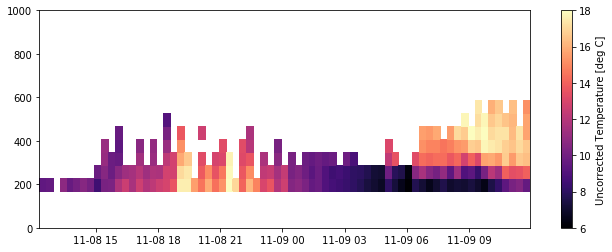

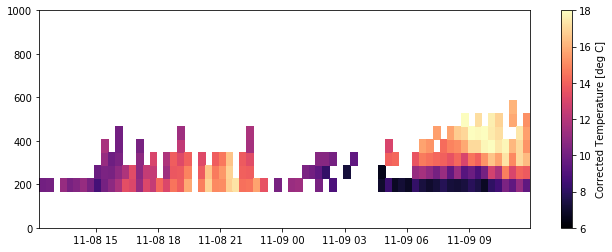

In [69]:
vmin,vmax = 6,18
cmap = 'magma'
zrange = (0,1000)

fig,ax = plt.subplots(figsize=(11,4))
pcm = ax.pcolormesh(tt,zz,rass['T'].unstack(),
                    cmap=cmap,vmin=vmin,vmax=vmax)
cbar = fig.colorbar(pcm)
cbar.set_label('Uncorrected Temperature [deg C]')
ax.set_ylim(zrange)

fig,ax = plt.subplots(figsize=(11,4))
pcm = ax.pcolormesh(tt,zz,rass['Tc'].unstack(),
                    cmap=cmap,vmin=vmin,vmax=vmax)
cbar = fig.colorbar(pcm)
cbar.set_label('Corrected Temperature [deg C]')
ax.set_ylim(zrange)